## Benchmark Model for crash prediction
### Developed by: bpben
#### Details steps of data processing, feature engineering and model tuning/testing for crash and road data

In [1]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from glob import glob
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from scipy.stats import describe

Helpers for tuning/testing models, available [here](https://github.com/bpben/model_helpers) as well

In [276]:
import numpy as np
import pandas as pd
import sklearn.ensemble as ske
import sklearn.svm as svm
import sklearn.linear_model as skl
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, KFold, StratifiedKFold, GroupKFold, GroupShuffleSplit
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler

class Indata():
    scoring = None
    data = None
    train_x, train_y, test_x, test_y = None, None, None, None
    is_split = 0
    
    #init with pandas DF and target column name, specify scoring observations
    def __init__(self, data, target, scoring=None):
        #If scoring observations, store under scoring attribute
        if scoring is not None:
            self.data = data[~(scoring)]
            self.scoring = data[scoring]
        else:
            self.data = data
        self.target = target
    
    # Split into train/test
    # pct : percent training observations
    # datesort : specify date column for sorting values
    #   If this is not None, split will be non-random (i.e. split on sorted obs)
    def tr_te_split(self, pct, datesort=None, group_col=None):
        """
        Split into train/test
        pct : percent training observations
        datesort : specify date column for sorting values
            If this is not None, split will be non-random (i.e. split on sorted obs)
        group_col : group column name for groupkfold split
            Will also be passed to tuner
        """
        if group_col:
            self.group_col = group_col
            grouper = GroupShuffleSplit(n_splits=1, train_size=pct)
            g = grouper.split(self.data, groups=self.data[group_col])
            # get the actual indexes of the training set
            inds, _ = tuple(*g)
            # translate that into boolean array
            inds = self.data.index[inds]
            inds = self.data.index.isin(inds)
        elif datesort:
            self.data.sort_values(datesort, inplace=True)
            self.data.reset_index(drop=True, inplace=True)
            inds = np.arange(0.0,len(self.data)) / len(self.data) < pct
        else:
            inds = np.random.rand(len(self.data)) < pct
        self.train_x = self.data[inds]
        print 'Train obs:', len(self.train_x)
        self.train_y = self.data[self.target][inds]
        self.test_x = self.data[~inds]
        print 'Test obs:', len(self.test_x)
        self.test_y = self.data[self.target][~inds]
        self.is_split = 1
        
class Tuner():
    """
    Initiates with indata class, will tune series of models according to parameters.  
    Outputs RandomizedGridCV results and parameterized model in dictionary
    """
    
    data = None
    train_x, train_y = None, None
    group_col = None
    
    def __init__(self, indata, best_models=None, grid_results=None):
        if indata.is_split == 0:
            raise ValueError('Data is not split, cannot be tested')
        # check if grouped by some column
        if hasattr(indata,'group_col'):
            self.group_col = indata.group_col
        self.data = indata.data
        self.train_x = indata.train_x
        self.train_y = indata.train_y
        if best_models is None:
            self.best_models = {}
        if grid_results is None:
            self.grid_results = pd.DataFrame()
        
            
    def make_grid(self, model, cvparams, mparams):
        #Makes CV grid
        # to implement, no capability for GroupKFold for randomizedsearch
        #if self.group_col:
            #cv = GroupKFold(cvparams['folds'])
        grid = RandomizedSearchCV(
                    model(),scoring=cvparams['pmetric'], 
                    cv = KFold(cvparams['folds'], cvparams['shuffle']),
                    refit=False, n_iter=cvparams['iter'],
                    param_distributions=mparams, verbose=1)
        return(grid)
    
    def run_grid(self, grid, train_x, train_y):
        grid.fit(train_x, train_y)
        results = pd.DataFrame(grid.cv_results_)[['mean_test_score','mean_train_score','params']]
        best = {}
        best['bp'] = grid.best_params_
        best[grid.scoring] = grid.best_score_
        return(best, results)
            
    def tune(self, name, m_name, features, cvparams, mparams):
        if hasattr(ske, m_name):
            model = getattr(ske, m_name)
        elif hasattr(skl, m_name):
            model = getattr(skl, m_name)
        elif hasattr(xgb, m_name):
            model = getattr(xgb, m_name)
        elif hasattr(svm, m_name):
            model = getattr(svm, m_name)
        else:
            raise ValueError('Model name is invalid.')
        grid = self.make_grid(model, cvparams, mparams)
        best, results = self.run_grid(grid, self.train_x[features], self.train_y)
        results['name'] = name
        results['m_name'] = m_name
        self.grid_results = self.grid_results.append(results)
        best['model'] = model(**best['bp'])
        best['features'] = list(features)
        self.best_models.update({name: best}) 
        
class Tester():
    """
    Initiates with indata class, receives parameterized sklearn models, prints and stores results
    """
    
    def __init__(self, data, rundict=None):
        if data.is_split == 0 :
            raise ValueError('Data is not split, cannot be tested')
        else:
            self.data = data
            if rundict is None:
                self.rundict = {}
            
    def init_tuned(self, tuned):
        """ pass Tuner object, populatest with names, models, features """
        if tuned.best_models=={}:
            raise ValueError('No tuned models found')
        else:
            self.rundict.update(tuned.best_models)
    
    def predsprobs(self, model, test_x):
        """ Produce predicted class and probabilities """
        # if the model doesn't have predict proba, will be treated as GLM
        if hasattr(model, 'predict_proba'):
            preds = model.predict(test_x)
            probs = model.predict_proba(test_x)[:,1]
        else:
            probs = model.predict(test_x)
            preds = (probs>=.5).astype(int)
        return(preds, probs)
    
    def get_metrics(self, preds, probs, test_y):
        """ Produce metrics (f1 score, AUC, brier) """
        # if test is not binary, just run brier
        if len(np.unique(test_y))==2:
            f1_s = metrics.f1_score(test_y, preds)
            roc = metrics.roc_auc_score(test_y, probs)
        else:
            f1_s, roc = None, None
        brier = metrics.brier_score_loss(test_y, probs)
        return(f1_s, roc, brier)
    
    def make_result(self, model, test_x, test_y):
        """ gets predictions and runs metrics """
        preds, probs = self.predsprobs(model, test_x)
        f1_s, roc, brier = self.get_metrics(preds, probs, test_y)
        print "f1_score: ", f1_s
        print "roc auc: ", roc
        print "brier_score: ", brier
        result = {}
        result['f1_s'] = f1_s
        result['roc'] = roc
        result['brier'] = brier
        return(result)

    
    def run_model(self, name, model, features, cal=True, cal_m='sigmoid'):
        """
        Run a specific model (not from Tuner classs)
        By default, calibrates predictions and produces metrics for them
        Will also store in rundict object
        """

        results = {}
        results['features'] = list(features)
        results['model'] = model
        print "Fitting {} model with {} features".format(name, len(features))
        if cal:
            # Need disjoint calibration/training datasets
            # Split 50/50
            rnd_ind = np.random.rand(len(self.data.train_x)) < .5
            train_x = self.data.train_x[features][rnd_ind]
            train_y = self.data.train_y[rnd_ind]
            cal_x = self.data.train_x[features][~rnd_ind]
            cal_y = self.data.train_y[~rnd_ind]
        else:
            train_x = self.data.train_x[features]
            train_y = self.data.train_y

        m_fit = model.fit(train_x, train_y)
        result = self.make_result(
            m_fit,
            self.data.test_x[features],
            self.data.test_y)

        results['raw'] = result
        results['m_fit'] = m_fit
        if cal:
            print "calibrated:"
            m_c = CalibratedClassifierCV(model, method = cal_m)
            m_fit_c = m_c.fit(cal_x, cal_y)
            result_c = self.make_result(m_fit_c, self.data.test_x[features], self.data.test_y)
            results['calibrated'] = result_c              
            print "\n"
        if name in self.rundict:
            self.rundict[name].update(results)
        else:
            self.rundict.update({name:results})
    
    def run_tuned(self, name, cal=True, cal_m='sigmoid'):
        """ Wrapper for run_model when using Tuner object """
        self.run_model(name, self.rundict[name]['model'], self.rundict[name]['features'], cal, cal_m)

/Users/B/anaconda/envs/boston-crash-model/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Data processing
The approach here is to create 3 time-lag features:

1. crashes in the past week
2. crashes in the past month
3. crashes in the past quarter (three months)
4. average crashes per week up to target week

All features except 4 are calculated to exclude one another.  That is, crashes in the past month does not include the past week's crashes.  Crashes in the past quarter do not include the past month.

In [277]:
SEG_CHARS = ['AADT', 'SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class']

In [278]:
# Read in data
data = pd.read_csv('../../data/processed/vz_predict_dataset.csv.gz', compression='gzip', dtype={'segment_id':'str'})
data.sort_values(['segment_id', 'year', 'week'], inplace=True)

In [279]:
# get segments with non-zero crashes
data_nonzero = data.set_index('segment_id').loc[data.groupby('segment_id').crash.sum()>0]
data_nonzero.reset_index(inplace=True)

In [280]:
def format_crash_data(data, col, target_week, target_year):
    """ formats crash data for train/test 
    target_week: week to predict (make into binary target)
    target_year: year for predicted week
    note: data must be available for 4 months prior to target
    gets previous week count, previous month count, previous quarter count, avg per week
    """
    assert target_week>16
    pre_week = target_week - 1
    pre_month = range(pre_week-4, target_week)
    pre_quarter = range(pre_month[0]-12, target_week)
    
    # week interval for each segment
    # full range = pre_quarter : target
    sliced = data.loc[(slice(None),slice(target_year,target_year), slice(1, target_week)),:]
    week_data = sliced[col].unstack(2)
    week_data.reset_index(level=1, inplace=True)
    
    # aggregate
    week_data['pre_month'] = week_data[pre_month].sum(axis=1)
    week_data['pre_quarter'] = week_data[pre_quarter].sum(axis=1)
    week_data['pre_week'] = week_data[pre_week]

    # avg as of target week
    except_target = data.loc[(slice(None),
                       slice(target_year,target_year),
                       slice(target_week,None)),:].index
    avg_week = data.drop(except_target)
    avg_week = avg_week.reset_index().groupby('segment_id')[col].mean()
    avg_week.name = 'avg_week'
    # join to week data
    week_data = week_data.join(avg_week)

    # binarize target
    week_data['target'] = (week_data[target_week]>0).astype(int)
    week_data = week_data.reset_index()

    return(week_data[['segment_id','target', 'pre_week',
                      'pre_month', 'pre_quarter', 'avg_week']])

In [281]:
# simple add concern, any concern reported 2016
concern_observed = data_nonzero[data_nonzero.year==2016].groupby('segment_id').concern.max()
concern_observed.name = 'concern_observed'

In [282]:
crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','year','week']), 'crash', 19, 2017)

In [283]:
data_segs = data_nonzero.groupby('segment_id')[SEG_CHARS].max()  # grab the highest values from each column for a segment, not used in model?
data_segs.reset_index(inplace=True)

In [284]:
data_model = crash_lags.merge(data_segs, left_on='segment_id', right_on='segment_id')

In [285]:
# add concerns
data_model = data_model.merge(concern_observed.reset_index(), on='segment_id')

In [286]:
# Add in adjacency info
adj_info = pd.read_csv('../../data/processed/adjacency_info.csv', usecols=['segment_id', 'orig_id'],
                       dtype={'segment_id':'str', 'orig_id':'str'})

# link adjacent segments for segments with crashes
adj_info = adj_info[adj_info.segment_id.isin(data_model.segment_id)]
adj_mat = adj_info.merge(adj_info, on='orig_id')
adj_mat = adj_mat[['segment_id_x', 'segment_id_y']]
adj_mat.drop_duplicates(inplace=True)
# including segments with only self-adjacent
# for this, need to ensure they don't join to their own data
adj_mat.loc[adj_mat.segment_id_x==adj_mat.segment_id_y, 'segment_id_y'] = np.NaN

def get_adj_crash_lags(target_week, target_year):
    """calculate total number of crashes that occurred 
    in adjacent segments for target week and lags as defined in format_crash_data
    """ 
    lag_data = format_crash_data(data_nonzero.set_index(['segment_id','year','week']), 'crash', target_week, target_year)
    merge_lags = adj_mat.merge(lag_data, left_on='segment_id_y', right_on='segment_id', how='left')
    adj_lags = merge_lags.groupby(['segment_id_x'])['pre_week', 'pre_month', 'pre_quarter'].sum()
    return adj_lags

adj_lags = get_adj_crash_lags(19, 2017)

In [287]:
# fill those with only self-adj zero
adj_lags.fillna(0, inplace=True)

In [288]:
data_model = data_model.merge(adj_lags, how='left', left_on='segment_id', right_index=True, suffixes=('', '_adj'))
data_model.fillna(0, inplace=True)

In [289]:
# standardize for LR
#from sklearn.preprocessing import scale
#data_scaled = pd.DataFrame(scale(data_model['AADT', 'SPEEDLIMIT']), 
#                          columns=[f+'_scaled' for f in features])
#data_model = pd.concat([data_model, data_scaled], axis=1)

In [290]:
# trying a different feature set
dummy_att = ['SPEEDLIMIT', 'Struct_Cnd', 'Surface_Tp', 'F_F_Class']
for d in dummy_att:
    t = pd.get_dummies(data_model[d])
    t.columns = [d+str(c) for c in t.columns]
    data_model = pd.concat([data_model, t], axis=1)
# aadt - log-transform
data_model['log_aadt'] = np.log(data_model.AADT+1)
# add segment type
data_model['intersection'] = data_model.segment_id.map(lambda x: x[:2]!='00').astype(int)
# features
features = data_model.filter(regex='[0-9]').columns.tolist() + ['log_aadt', 'intersection']

In [332]:
# Features
#features = [u'pre_week', u'pre_month', u'pre_quarter', 'avg_week', u'AADT', u'SPEEDLIMIT',
#            u'Struct_Cnd', u'Surface_Tp', u'F_F_Class', u'pre_week_adj', 
#            u'pre_month_adj', u'pre_quarter_adj']
features += [u'pre_week', u'pre_month', u'pre_quarter', 'avg_week', 'concern_observed']
lm_features = list(set(features) - set(['SPEEDLIMIT1', 'Struct_Cnd0', 'F_F_Class0']))

### Model tuning
This uses the model helpers above.  They're based on sklearn and implement a randomized grid search with K-fold crossvalidation.

In [333]:
#Initialize data
df = Indata(data_model, 'target')
#Create train/test split
df.tr_te_split(.7)

Train obs: 2396
Test obs: 982


In [334]:
#Parameters for model
# class weight
a = data_model['target'].value_counts(normalize=True)
w = 1/a[1]
#Model parameters
params = dict()

#cv parameters
cvp = dict()
cvp['pmetric'] = 'roc_auc'
cvp['iter'] = 5 #number of iterations
cvp['folds'] = 5 #folds for cv (default)
cvp['shuffle'] = True

#LR parameters
mp = dict()
mp['LogisticRegression'] = dict()
mp['LogisticRegression']['penalty'] = ['l1','l2']
mp['LogisticRegression']['C'] = ss.beta(a=5,b=2) #beta distribution for selecting reg strength
mp['LogisticRegression']['class_weight'] = ['balanced']

#RF model parameters
mp['RandomForestClassifier'] = dict()
mp['RandomForestClassifier']['n_estimators'] = [2**8] #number of trees in the forest
mp['RandomForestClassifier']['max_features'] = ss.beta(a=5,b=1) #number of features at split
mp['RandomForestClassifier']['max_leaf_nodes'] = ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves to create
#mp['RandomForestClassifier']['class_weight'] = ['balanced']
mp['RandomForestClassifier']['class_weight'] = [{0:1,1:w}]


#xgBoost model parameters
mp['XGBClassifier'] = dict()
mp['XGBClassifier']['max_depth'] = range(3, 7)
mp['XGBClassifier']['min_child_weight'] = range(1, 5)
mp['XGBClassifier']['learning_rate'] = ss.beta(a=2,b=15)
mp['XGBClassifier']['scale_pos_weight'] = [w]

In [335]:
#Initialize tuner
tune = Tuner(df)

In [336]:
#Base XG model
tune.tune('XG_base', 'XGBClassifier', feats, cvp, mp['XGBClassifier'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.9s finished


In [337]:
#Base RF model
tune.tune('RF_base', 'RandomForestClassifier', features, cvp, mp['RandomForestClassifier'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.1min finished


In [338]:
#Base LR model
tune.tune('LR_base', 'LogisticRegression', lm_features, cvp, mp['LogisticRegression'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.8s finished


In [339]:
#Display results
tune.grid_results

,mean_test_score,mean_train_score,params,name,m_name
0,0.539715,0.952102,"{u'scale_pos_weight': 61.4181818182, u'learnin...",XG_base,XGBClassifier
1,0.525479,0.956909,"{u'scale_pos_weight': 61.4181818182, u'learnin...",XG_base,XGBClassifier
2,0.524591,0.967394,"{u'scale_pos_weight': 61.4181818182, u'learnin...",XG_base,XGBClassifier
3,0.608078,0.882563,"{u'scale_pos_weight': 61.4181818182, u'learnin...",XG_base,XGBClassifier
4,0.526709,0.974394,"{u'scale_pos_weight': 61.4181818182, u'learnin...",XG_base,XGBClassifier
0,0.717272,0.998635,"{u'max_features': 0.706051623971, u'max_leaf_n...",RF_base,RandomForestClassifier
1,0.663105,0.998573,"{u'max_features': 0.941033684712, u'max_leaf_n...",RF_base,RandomForestClassifier
2,0.689439,0.998813,"{u'max_features': 0.967993207111, u'max_leaf_n...",RF_base,RandomForestClassifier
3,0.674742,0.998373,"{u'max_features': 0.976994307592, u'max_leaf_n...",RF_base,RandomForestClassifier
4,0.656144,0.998308,"{u'max_features': 0.962203448832, u'max_leaf_n...",RF_base,RandomForestClassifier


In [343]:
# Run test
test = Tester(df)
test.init_tuned(tune)
test.run_tuned('RF_base', cal=False)
test.run_tuned('LR_base', cal=False)
test.run_tuned('XG_base', cal=False)

Fitting RF_base model with 47 features
f1_score:  0.0
roc auc:  0.733706438041
brier_score:  0.0202538773754
Fitting LR_base model with 39 features
f1_score:  0.048275862069
roc auc:  0.68536159403
brier_score:  0.203287799165
Fitting XG_base model with 34 features
f1_score:  0.0366972477064
roc auc:  0.493490513614
brier_score:  0.197440885928


In [218]:
# Check feature importance
f_importance = tune.best_models['RF_base']['m_fit'].feature_importances_
fi = list(zip(features, f_importance))
print sorted(fi, key=lambda x: x[1], reverse=True)

[('avg_week', 0.32507639564755558), ('log_aadt', 0.22485744120301215), (u'pre_quarter_adj', 0.059371346519650092), (u'pre_quarter', 0.053484976004599435), ('SPEEDLIMIT65', 0.029754818922582284), ('SPEEDLIMIT30', 0.026276479394543847), (u'pre_month', 0.024586739996401846), ('intersection', 0.024488403968206816), ('Struct_Cnd3', 0.024207253081065982), ('SPEEDLIMIT25', 0.022829649253267047), ('F_F_Class7', 0.022777549405308163), ('Struct_Cnd2', 0.021728773144841725), ('SPEEDLIMIT20', 0.018320723235497657), (u'pre_month_adj', 0.017671485215904507), ('Struct_Cnd1', 0.015729358042721284), ('SPEEDLIMIT35', 0.011669354535281845), ('Struct_Cnd4', 0.010434214036467788), ('F_F_Class4', 0.0075860682292713082), ('F_F_Class3', 0.0074437118448320216), ('Surface_Tp6', 0.0073283207325600935), ('SPEEDLIMIT1', 0.0062811429632111844), ('SPEEDLIMIT15', 0.006004979081340696), (u'pre_week_adj', 0.0054213710980202815), ('F_F_Class1', 0.0049075051004588569), ('F_F_Class0', 0.0043596561595910435), ('Surface_Tp5

In [318]:
from sklearn.metrics import roc_auc_score

In [327]:
# trying some other models
minus_adj = list(set(lm_features) - set([x for x in lm_features if x.find('adj')!=-1]))
lr = skl.LogisticRegression(**test.rundict['LR_base']['bp'])
lr.fit(test.data.train_x[minus_adj], test.data.train_y)
preds = lr.predict_proba(
    test.data.test_x[minus_adj])[::,1]
roc_auc_score(test.data.test_y, preds)

0.57538461538461538

In [321]:
# trying some other models
minus_adj = list(set(lm_features) - set([x for x in lm_features if x.find('adj')!=-1]))
lr = skl.LogisticRegression(**test.rundict['LR_base']['bp'])
lr.fit(test.data.train_x[minus_adj], test.data.train_y)
preds = lr.predict_proba(
    test.data.test_x[minus_adj])[::,1]
roc_auc_score(test.data.test_y, preds)

[u'pre_quarter_adj', u'pre_week_adj', u'pre_month_adj']

In [331]:
lr = skl.LogisticRegression(**test.rundict['LR_base']['bp'])
lr.fit(test.data.train_x['avg_week'].reshape(-1,1), test.data.train_y)
preds = lr.predict_proba(
    test.data.test_x['avg_week'].reshape(-1,1))[::,1]
roc_auc_score(test.data.test_y, preds)

/Users/B/anaconda/envs/boston-crash-model/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/B/anaconda/envs/boston-crash-model/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


0.55830546265328862

### Lift chart by "risk bin"
The classifier problem is difficult because the classes are unbalanced (.05% have crashes at target week).  More useful are the probabilities being produced by the model, which give some idea of risk.

In [344]:
def lift_chart(x_col, y_col, data, ax=None):

    p = sns.barplot(x=x_col, y=y_col, data=data, 
                    palette='Reds', ax = None, ci=None)
    vals = p.get_yticks()
    p.set_yticklabels(['{:3.0f}%'.format(i*100) for i in vals])
    xvals = [x.get_text().split(',')[-1].strip(']') for x in p.get_xticklabels()]
    xvals = ['{:3.0f}%'.format(float(x)*100) for x in xvals]
    p.set_xticklabels(xvals)
    p.set_facecolor('white')
    p.set_xlabel('')
    p.set_ylabel('')
    p.set_title('Predicted probability vs actual percent')
    return(p)
    
def density(data, score, ax=None):
    p = sns.kdeplot(risk_df['risk_score'], ax=ax)
    p.set_facecolor('white')
    p.legend('')
    p.set_xlabel('Predicted probability of crash')
    p.set_title('KDE plot predictions')
    return(p)

In [345]:
risk_scores = test.rundict['RF_base']['m_fit'].predict_proba(test.data.test_x[features])[:,1]
risk_df = pd.DataFrame({'risk_score':risk_scores, 'crash':test.data.test_y})
print risk_df.risk_score.describe()
risk_df['categories'] = pd.cut(risk_df['risk_score'], bins=[-1, 0, .01, .02, .05, max(risk_scores)])
risk_mean = risk_df.groupby('categories')['crash'].count()
print risk_mean

count    982.000000
mean       0.031068
std        0.085986
min        0.000000
25%        0.000000
50%        0.000000
75%        0.011673
max        0.660301
Name: risk_score, dtype: float64
categories
(-1, 0]         628
(0, 0.01]       105
(0.01, 0.02]     53
(0.02, 0.05]     63
(0.05, 0.66]    133
Name: crash, dtype: int64


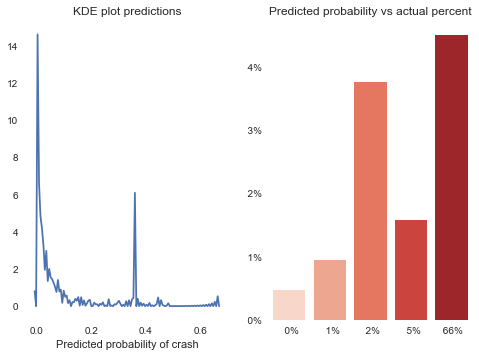

In [346]:
fig, axes = plt.subplots(1, 2)
lift_chart('categories', 'crash', risk_df, 
           ax=axes[1])
density(risk_df, 'risk_score', ax=axes[0])

In [53]:
# output predictions
# predict on all segments
data_model['risk_score'] = test.rundict['RF_base']['m_fit'].predict_proba(data_model[features])[:,1]
data_model.to_csv('seg_with_risk_score_adj.csv', index=False)

### Check sensitivity to week
I predicted an arbitrary week as target here, but I'd like to see whether things change significantly if I change that week.  A good metric to measure that is brier score loss.  It'll be low throughout as the classifier doesn't perform great, but it shouldn't vary a huge amount.

In [100]:
def run_model_for_week(weeks=[20, 30, 40, 50], output=False):
    for w in [20, 30, 40, 50]:
        print "week ", w
        crash_lags = format_crash_data(data_nonzero.set_index(['segment_id','year','week']), 'crash', w, 2016)
        data = crash_lags.merge(data_segs, left_on='segment_id', right_on='segment_id')
        adj_lags = get_adj_crash_lags(w, 2016)
        data = data.merge(adj_lags, left_on='segment_id', right_index=True, suffixes=('', '_adj'))
        data.fillna(0, inplace=True)
        df = Indata(data, 'target')
        # create train/test split
        df.tr_te_split(.7)
        test = Tester(df)
        test.init_tuned(tune)
        test.run_tuned('LR_base', cal=False)
        print '\n'
    if output==True:
        return(test.rundict['LR_base']['m_fit'].pred)

In [101]:
run_model_for_week()

week  20
Train obs: 2367
Test obs: 1011
Fitting LR_base model with 12 features


KeyError: "[u'pre_week_scaled' u'pre_month_scaled' u'pre_quarter_scaled'\n 'avg_week_scaled' u'AADT_scaled' u'SPEEDLIMIT_scaled' u'Struct_Cnd_scaled'\n u'Surface_Tp_scaled' u'F_F_Class_scaled' u'pre_week_adj_scaled'\n u'pre_month_adj_scaled' u'pre_quarter_adj_scaled'] not in index"

In [ ]:
# week predictions output
